In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.analysis import distances
from tqdm import tqdm
from numpy import linalg as LA
from scipy.signal import lfilter

sys.path.append("../py_modules/")

from utils import sparse_to_full, triu_to_full

In [2]:
runs = sorted(glob.glob("../clustering_40_sys/pdb_save_clustering/comp*"))

In [10]:
nsp10_int_res = np.array([[4293, 4300], [4322, 4337], [4346, 4349]])
nsp16_int_res = np.array([[6835, 6846], [6874, 6889], [6900, 6908], [7042, 7046]])

In [3]:
df = []

for run in runs[:]: 
    clusters = sorted(glob.glob(f"{run}/cluster_*"))
    for cluster in tqdm(clusters[:]): 
        pdbs = sorted(glob.glob(f"{cluster}/*.pdb")) 
        mda_u = mda.Universe(pdbs[0], pdbs)
        
        nsp10 = mda_u.select_atoms('protein and name CA and segid B')
        nsp16 = mda_u.select_atoms('protein and name CA and segid A')
        
        contact_maps = []
        for _ in mda_u.trajectory: 
            dist_map = distances.distance_array(
                        nsp10.positions, nsp16.positions, 
                        box=nsp10.dimensions)
            contact_map = (dist_map < 10) * 1
            contact_maps.append(contact_map)
            
        contact_maps_mean = np.mean(contact_maps, axis=0)
        df.append({"sys_name": os.path.basename(run), 
                   "cluster_name": os.path.basename(cluster), 
                   "contact_map": contact_maps_mean})

  0%|          | 0/26 [00:00<?, ?it/s]/homes/heng.ma/miniconda3/envs/MD_ff/lib/python3.6/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")
100%|██████████| 28/28 [01:06<00:00,  2.37s/it]


In [4]:
df = pd.DataFrame(df)
df

,sys_name,cluster_name,contact_map
0,comp,cluster_000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,comp,cluster_001,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,comp,cluster_002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,comp,cluster_003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,comp,cluster_004,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
100,comp_sfg,cluster_023,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
101,comp_sfg,cluster_024,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
102,comp_sfg,cluster_025,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
103,comp_sfg,cluster_026,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [31]:
df.to_pickle('cm_cluster.pkl')

In [30]:
cm0 = df.iloc[0]['contact_map']

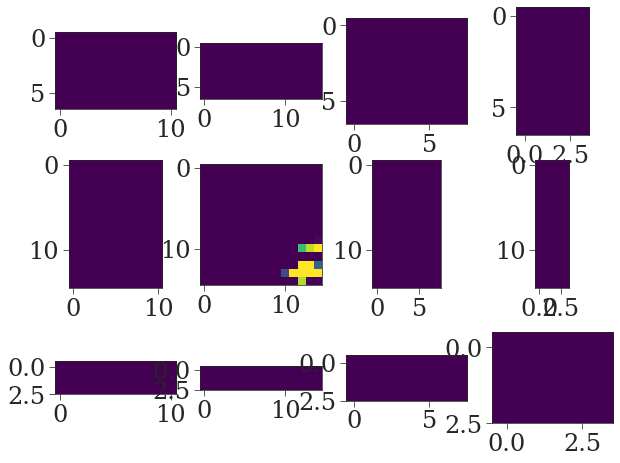

In [29]:
fig, axes = plt.subplots(3, 4, figsize=(10, 8)) 

for i, nsp10_res in enumerate(nsp10_int_res): 
    nsp10_res = nsp10_res - 4271
    for j, nsp16_res in enumerate(nsp16_int_res): 
        nsp16_res = nsp16_res - 6798
        ax = axes[i, j]
        
        ax.imshow(cm0[nsp10_res[0]:nsp10_res[1], nsp16_res[0]:nsp16_res[1]], cmap='viridis')
    

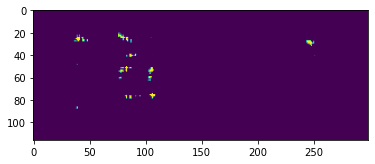

In [6]:
plt.imshow(df.iloc[0]['contact_map'])

In [8]:
nsp16.residues[0]

<Residue ALA, 6798>

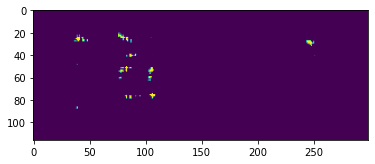

In [13]:
plt.imshow(contact_maps_mean)

In [3]:
contact_maps = []
cutoff = 10
for run in tqdm(runs[:1]):
    pdb_file = run
    dcd_file = run.replace("pdb", "dcd")

    run_base = os.path.basename(run)[:-4]
    if run.split('/')[-2] == 'Nsp10_Nsp16': 
        run_base += '_000'
    elif run.split('/')[-2].endswith('mono'): 
        continue

    mda_traj = mda.Universe(pdb_file, dcd_file)

    nsp16 = mda_traj.select_atoms("segid A")
    nsp10 = mda_traj.select_atoms("segid B")
#     no_sol = mda_traj.select_atoms("protein")
#     cm_list = []
    
    nsp16_ca = nsp16.select_atoms('name CA') 
    nsp10_ca = nsp10.select_atoms('name CA')
#     protein_ca = mda_traj.select_atoms('protein and name CA')
    for ts in mda_traj.trajectory[:]:
        cm  = (distances.distance_array(
            nsp10_ca.positions, nsp16_ca.positions, 
#             protein_ca.positions, 
            box = ts.dimensions) < cutoff) * 1
#         print(np.where(cm==1)[0].shape, len(cm), triu_to_full(cm).shape)
#         print(cm.shape)
        
        contact_maps.append(cm)

100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


In [4]:
# contact_maps = df.contact_maps.to_numpy()
contact_maps = np.array(contact_maps)
contact_maps.shape

(10000, 116, 299)

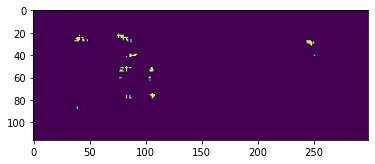

In [6]:
plt.imshow(contact_maps[0])

In [10]:
nsp10_contact_atom, nsp16_contact_atom = np.where(contact_maps[0] == 1)

In [15]:
def print_res_info(atom): 
    return f'{atom.resname}-{atom.resnum}'

In [27]:
contact_res = []
for i in np.unique(nsp10_contact_atom):
    atom = nsp10_ca[i]
    contact_res.append({'chain': 'nsp10', 'resname': atom.resname, 'resnum': atom.resnum})

for i in np.unique(nsp16_contact_atom):
    atom = nsp16_ca[i]
    contact_res.append({'chain': 'nsp16', 'resname': atom.resname, 'resnum': atom.resnum})

In [29]:
contact_res = pd.DataFrame(contact_res)
contact_res.to_pickle('contact_res_nsp10_nsp16.pkl')
contact_res

,chain,resname,resnum
0,nsp10,THR,4292
1,nsp10,ASN,4293
2,nsp10,CYS,4294
3,nsp10,VAL,4295
4,nsp10,LYS,4296
...,...,...,...
64,nsp16,MET,7045
65,nsp16,SER,7046
66,nsp16,LYS,7047
67,nsp16,PHE,7048


In [6]:
# padding if odd dimension occurs in image
padding = 8
pad_f = lambda x: (0,0) if x%padding == 0 else (0,padding-x%padding)
padding_buffer = [(0,0)]
for x in contact_maps.shape[1:]:
    padding_buffer.append(pad_f(x))
contact_maps = np.pad(contact_maps, padding_buffer, mode='constant')
print(contact_maps.shape)

(360000, 120, 304)


In [7]:
contact_maps = contact_maps.reshape((contact_maps.shape) + (1,))

In [9]:
import h5py 

h5_file = './' + f"/cvae_input_contact.h5"
cm_h5 = h5py.File(h5_file, 'w')
cm_h5.create_dataset('contact_maps', data=contact_maps)
# cm_h5.create_dataset('rmsd', data=rmsd_profs)
cm_h5.close()

In [9]:
df.to_pickle('cm_nsp10-16.pkl')

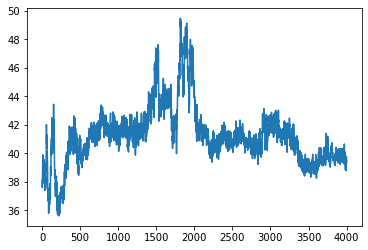

In [15]:
plt.plot(df[df['sys_name'] == 'comp_rna7jyy_072']['dist'].item())